In [1]:
from shortfall.sim import Simulator, SimConfig
from shortfall.miners.burn import BurnShortfallMinerState
from shortfall.miners.repay_ratchet import RepayRatchetShortfallMinerState
from shortfall.network import *
from shortfall.strategy import *
from shortfall.consts import *

import dataclasses
import matplotlib.pyplot as plt
import pandas as pd

network = dataclasses.replace(MAINNET_APR_2023,
    # The external "interest rate" % p.a. on leased tokens.
    token_lease_fee=0.20,
    # Try REWARD_DECAY + BASELINE_GROWTH to simulate the SP's share of power declining fast.
    reward_decay=REWARD_DECAY,
)
# Number of epochs to simulate.
epochs = 3 * YEAR + 1
# Frequency of statistics output.
stats_interval = DAY

In [2]:
def show_miner_accounting_charts(df):
    plt.figure()
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(13.4, 4.8))

    # Balance sheet
    ax1.grid(axis='y', color='#EEE')
    ax1.plot(df['day'], df['net_equity'], label="Net equity")
    ax1.plot(df['day'], df['balance'], label="Balance")
    ax1.plot(df['day'], df['available'], '--', label="Available")
    ax1.plot(df['day'], -df['lease'], label="Lease")
    ax1.plot(df['day'], df['pledge_locked'], '--', label="Pledge locked")
    ax1.plot(df['day'], df['vesting_locked'], '--', label="Vesting locked")
    ax1.set_title("Miner equity")
    ax1.set_xlabel("Day")
    ax1.set_ylabel("FIL")
    ax1.legend()

    # PnL
    ax2.grid(axis='y', color='#EEE')
    ax2.plot(df['day'], df['reward_earned'], label="Rewards")
    ax2.plot(df['day'], -df['fee_burned'], label="Shortfall fee")
    ax2.plot(df['day'], -df['lease_fee_accrued'], label="Lease fee")
    ax2.set_title("Miner cash flow")
    ax2.set_xlabel("Day")
    ax2.legend()

    plt.show()

def show_miner_fofr(df):
    plt.figure()
    plt.grid(axis='y', color='#EEE')
    plt.plot(df['day'], df['fofr'], label="FoFR")
    plt.title("Miner return on pledge")
    plt.xlabel("Day")
    plt.ylabel("FIL")
    plt.legend()
    plt.show()

def compare_configurations(cfgs, title):
    statss = {label: pd.DataFrame(Simulator(cfg).run_all(epochs, stats_interval)) for (label, cfg) in cfgs.items()}

    plt.figure()
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13.4, 4.8))

    for label, df in statss.items():
        ax1.plot(df['day'], df['net_equity'], label=label)
        ax2.plot(df['day'], df['fofr'], label=label)

    ax1.grid(axis='y', color='#EEE')
    ax1.set_title("Miner equity - " + title)
    ax1.set_xlabel("Day")
    ax1.set_ylabel("FIL")
    ax1.legend()

    ax2.grid(axis='y', color='#EEE')
    ax2.set_title("Miner return on pledge")
    ax2.set_xlabel("Day")
    ax2.set_ylabel("FoFR")
    ax2.legend()

    plt.show()

## Repay the shortfall

This mechanism requires the SP to repay the target initial pledge.
The maximum shortfall is calculated from a conservative estimate of repayment ability.
Some fraction of earned rewards is then burned as a fee, and another (larger) fraction,
for mandatory repayments until the shortfall is paid off.

The first simulation shows an SP taking maximum shortfall given a fixed amount of tokens
available to them (as a lease that incurs fees).

The table and charts show a running balance sheet and accumulated cash flow statement.

In [3]:
repay_miner_factory = RepayRatchetShortfallMinerState.factory(
    # The SP is assumed to lease all tokens (alt: opportunity cost of using owned tokens).
    balance=0,
    max_repayment_term=5 * YEAR,
    max_fee_reward_fraction=0.25,
    reward_projection_decay=REWARD_DECAY + BASELINE_GROWTH
)
cfg = SimConfig(
    network=network,
    strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, shortfall=1.0),
    miner_factory=repay_miner_factory,
)
stats = Simulator(cfg).run_all(epochs, stats_interval)
repay_shortfall_df = pd.DataFrame(data=stats)
repay_shortfall_df

,day,epoch,power,balance,lease,pledge_locked,vesting_locked,available,net_equity,fofr,reward_earned,fee_burned,lease_fee_accrued,pledge_required,shortfall,shortfall_pct
0,0,1,333873577721856,1000.0000,1000.0002,1000.0000,0.0000,0.0000,-0.0002,-0.0000,0.0000,0.0000,0.0002,2110.0617,1110.0617,52.61
1,1,2881,333873577721856,1002.6964,1000.4825,1000.0133,2.6831,0.0000,2.2139,0.0022,3.5966,0.8344,0.5483,2110.0617,1110.0484,52.61
2,2,5761,333873577721856,1005.3910,1000.9643,1000.0400,5.3510,0.0000,4.4266,0.0044,7.1921,1.6688,1.0966,2110.0617,1110.0218,52.61
3,3,8641,333873577721856,1008.0836,1001.4456,1000.0799,8.0037,0.0000,6.6379,0.0066,10.7864,2.5032,1.6452,2110.0617,1109.9818,52.60
4,4,11521,333873577721856,1010.7743,1001.9264,1000.1338,10.6405,0.0000,8.8479,0.0088,14.3796,3.3376,2.1941,2110.0617,1109.9280,52.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,1091,3142081,333873577721856,2608.0183,0.0000,2110.0617,169.6906,328.2660,2608.0183,1.4598,3318.6360,265.2914,445.3263,2110.0617,0.0000,0.00
1092,1092,3144961,333873577721856,2610.5647,0.0000,2110.0617,169.6915,330.8115,2610.5647,1.4610,3321.1824,265.2914,445.3263,2110.0617,0.0000,0.00
1093,1093,3147841,333873577721856,2613.1104,0.0000,2110.0617,169.6923,333.3563,2613.1104,1.4622,3323.7280,265.2914,445.3263,2110.0617,0.0000,0.00
1094,1094,3150721,333873577721856,2615.6551,0.0000,2110.0617,169.6931,335.9003,2615.6551,1.4633,3326.2728,265.2914,445.3263,2110.0617,0.0000,0.00


<Figure size 640x480 with 0 Axes>

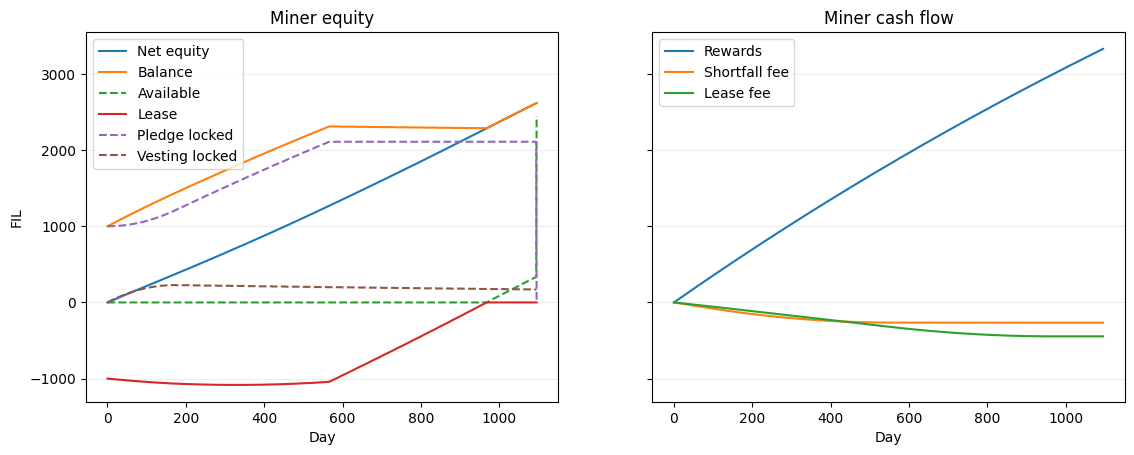

In [4]:
show_miner_accounting_charts(repay_shortfall_df)

<Figure size 640x480 with 0 Axes>

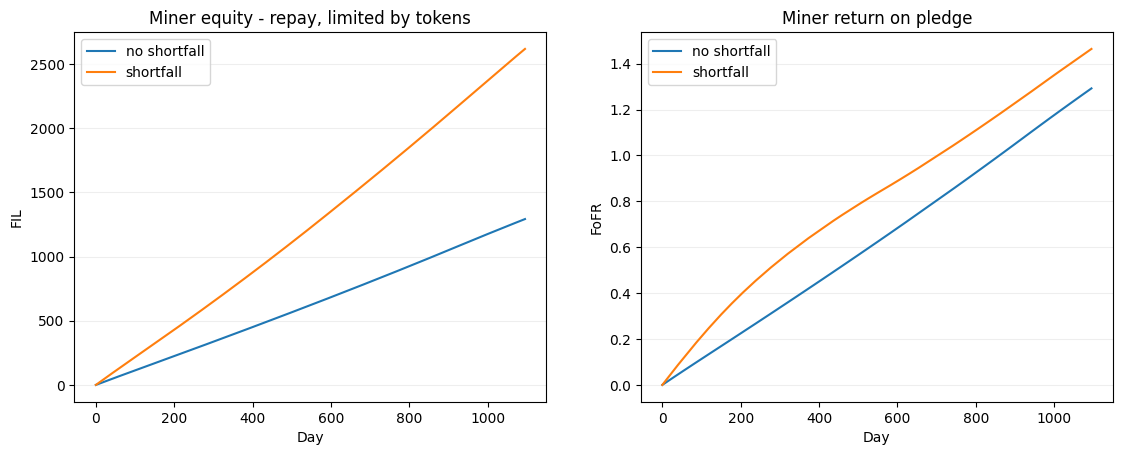

In [5]:
# Configurations limited by token availability.
# The SP is assumed to have abundant hardware and physical capacity, relative to the
# tokens available to them.
# They lock all tokens, and onboard as much power as permitted with/out a shortfall.
compare_configurations({
    'no shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, shortfall=0),
        miner_factory=repay_miner_factory,
    ),
    'shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, shortfall=1.0),
        miner_factory=repay_miner_factory,
    )
}, 'repay, limited by tokens')

<Figure size 640x480 with 0 Axes>

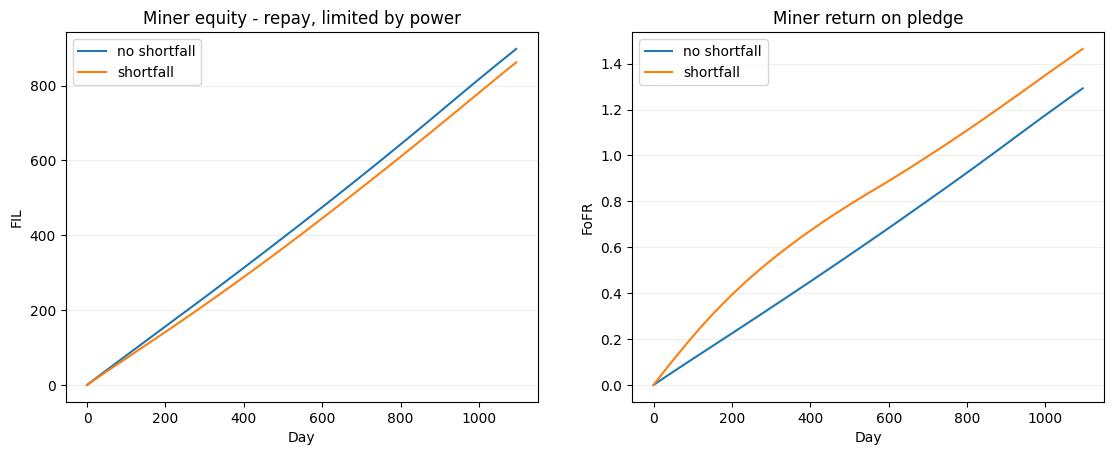

In [6]:
# Configurations limited by power
# The SP is assumed to have ample tokens available for them to lease, but a limited
# amount of power they can onboard (hardware and/or FIL+ data).
# The SP onboards their max power and the required pledge with/out a shortfall.
compare_configurations({
    'no shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.power_limited(100*TIBIBYTE, 3*YEAR, shortfall=0),
        miner_factory=repay_miner_factory,
    ),
    'shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.power_limited(100*TIBIBYTE, 3*YEAR, shortfall=1.0),
        miner_factory=repay_miner_factory,
    )
}, 'repay, limited by power')

## Burn the shortfall

This mechanism requires the SP to burn the difference between the notional initial pledge
and the amount they actually put at stake.
Tokens are burnt as a fraction of earned block rewards, the fraction depending on the
relative size of the outstanding obligation.

In [7]:
burn_miner_factory = BurnShortfallMinerState.factory(balance=0)
cfg = SimConfig(
    network=network,
    strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, shortfall=1.0),
    miner_factory=burn_miner_factory,
)
stats = Simulator(cfg).run_all(epochs, stats_interval)
burn_shortfall_df = pd.DataFrame(data=stats)
burn_shortfall_df


,day,epoch,power,balance,lease,pledge_locked,vesting_locked,available,net_equity,fofr,reward_earned,fee_burned,lease_fee_accrued,fee_pending,shortfall_pct
0,0,1,236154481803264,1000.0000,1000.0002,1000.0,0.0000,0.0000,-0.0002,-0.0000,0.0000,0.0000,0.0002,492.4827,33.00
1,1,2881,236154481803264,1001.0530,1000.1897,1000.0,1.0530,0.0000,0.8634,0.0009,2.5439,1.1324,0.5482,491.3503,32.95
2,2,5761,236154481803264,1002.1010,1000.3734,1000.0,2.1010,0.0000,1.7276,0.0017,5.0871,2.2631,1.0963,490.2196,32.90
3,3,8641,236154481803264,1003.1440,1000.5514,1000.0,3.1440,0.0000,2.5927,0.0026,7.6294,3.3923,1.6445,489.0904,32.84
4,4,11521,236154481803264,1004.1818,1000.7234,1000.0,4.1818,0.0000,3.4584,0.0035,10.1709,4.5197,2.1928,487.9630,32.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,1091,3142081,236154481803264,1579.3973,0.0000,1000.0,115.9378,463.4595,1579.3973,1.5794,2347.3279,488.7622,279.1685,3.7205,0.37
1092,1092,3144961,236154481803264,1581.1534,0.0000,1000.0,115.9574,465.1961,1581.1534,1.5812,2349.1290,488.8071,279.1685,3.6756,0.37
1093,1093,3147841,236154481803264,1582.9093,0.0000,1000.0,115.9769,466.9324,1582.9093,1.5829,2350.9296,488.8518,279.1685,3.6309,0.36
1094,1094,3150721,236154481803264,1584.6648,0.0000,1000.0,115.9963,468.6685,1584.6648,1.5847,2352.7295,488.8962,279.1685,3.5865,0.36


<Figure size 640x480 with 0 Axes>

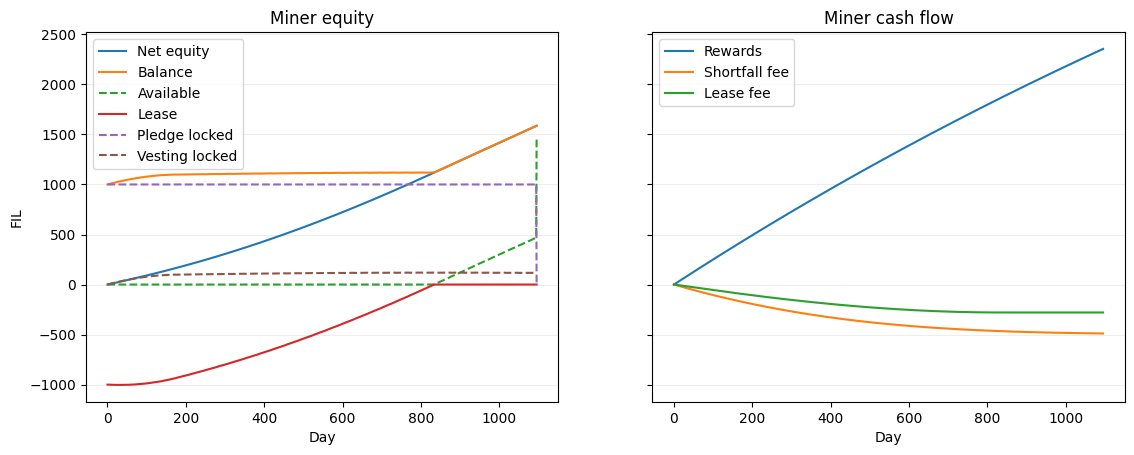

In [8]:
show_miner_accounting_charts(burn_shortfall_df)

<Figure size 640x480 with 0 Axes>

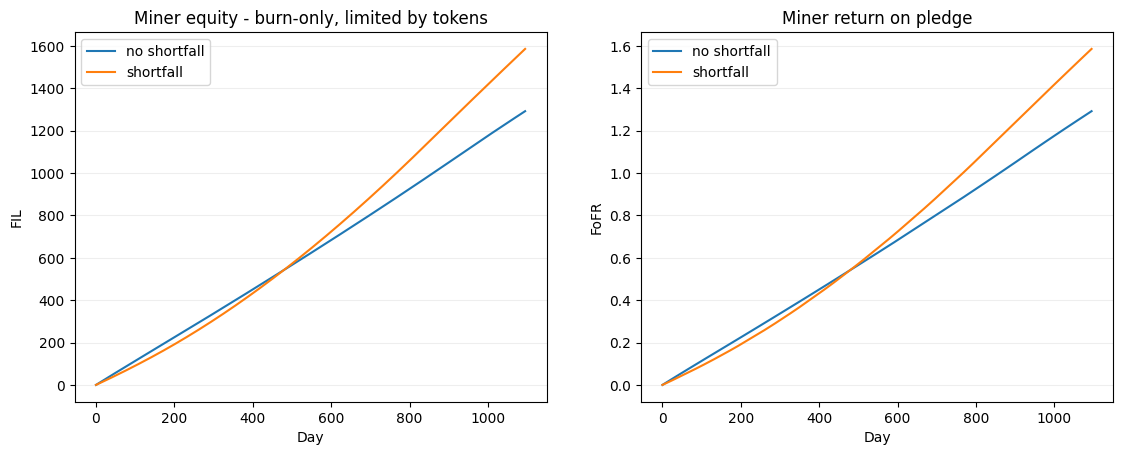

In [9]:
# Configurations limited by token availability.
compare_configurations({
    'no shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, shortfall=0),
        miner_factory=burn_miner_factory,
    ),
    'shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, shortfall=1.0),
        miner_factory=burn_miner_factory,
    )
}, 'burn-only, limited by tokens')


<Figure size 640x480 with 0 Axes>

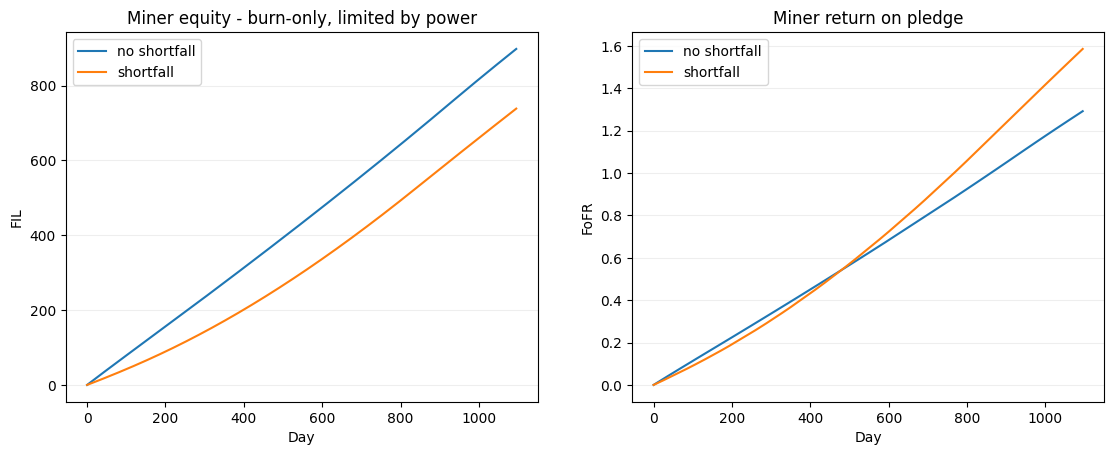

In [10]:
# Configurations limited by power.
compare_configurations({
    'no shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.power_limited(100 * TIBIBYTE, 3 * YEAR, shortfall=0),
        miner_factory=burn_miner_factory,
    ),
    'shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.power_limited(100 * TIBIBYTE, 3 * YEAR, shortfall=1.0),
        miner_factory=burn_miner_factory,
    )
}, 'burn-only, limited by power')
